# Analyzing RSNA X-Ray Data with Convolutional Neural Networks

Carter Koehler

The primary purpose of this dataset is to determine a person's age based on their bone structure examined in an x-ray. The real value of this is determining how mature a person's skeleton is to determine if the patient has any perceptible growth defects, especially for children. For example, if a person's skeleton indicates that they should be 7 years old, but they are in fact 10, they are likely suffering from some sort of endocrine disorder. However, there are not many good quantitative measures for this, even fewer of which are fast and fully automated.

If a prediction algorithm were able to compute the age of a person's skeleton based on their x-ray data, that is enough to determine whether they are suffering from endocrine dysfunction.

This test does not need to be perfect, but it should do a reasonable job at predicting the presence or absence of endocrine dysfuntion. In particular, this form of testing should serve as a basic, first-pass screen, so that hospitals can save money on doing more costly, but more precise, tests on each individual. As a basic screening technique, when predicting whether or not someone's bones are inside or outside of the tolerable range of their age, we should prioritze decreasing the false negative rate to decreasing the false positive rate. It is always easier to run a patient through extra tests to find out that they aren't affected than it is to turn away a patient who is affected.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['axes.grid'] = True

import os
import sys
from pprint import pprint
from IPython.display import SVG

from keras.models import Sequential
from keras.layers import Dense, Activation, Input, Dropout
from keras.layers import Embedding, Flatten, Merge, concatenate
from keras.layers import Conv2D, MaxPooling2D, Reshape
from keras.models import Model
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.optimizers import SGD, Adagrad, Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

## Data Preparation

In [2]:
file_dir = os.path.join(os.pardir, 'data')
compressed_dir = os.path.join(file_dir, 'boneage-compressed')

In [3]:
import pickle

boneage_data = np.array(pickle.load(open(os.path.join(compressed_dir, 'image_data.p'), 'rb')), dtype=int)

In [4]:
boneage_metadata = pd.read_csv(os.path.join(file_dir, 'boneage.csv')).iloc[:2000]

#convert from months to years
boneage_target = (boneage_metadata['boneage']/12).astype(int)
np.unique(boneage_target)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

So, we have 20 "classes." One could argue that they would be better served as a continuous variable, but then CNN's would be harder to apply to the problem. Also, we'll take this opportunity to remove any classes which we don't have enough data to reasonabl make predictions from.

In [5]:
small_classes = ~np.in1d(np.array(boneage_target), np.array([0, 18, 19]))

boneage_target = boneage_target[small_classes]
boneage_data = boneage_data[small_classes,:]

In [6]:
from skimage.io import imshow

# shamelessly stolen from https://github.com/eclarson/MachineLearningNotebooks/blob/master/04.%20Dimension%20Reduction%20and%20Images.ipynb

def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        
        plt.imshow(images[i,:].reshape((h, w)), cmap='bone')
            
        plt.xticks(())
        plt.yticks(())
    plt.show()

In [7]:
from PIL import Image, ImageEnhance

img_dim = 256
boneage_contrast = boneage_data.copy()

for i in range(boneage_target.shape[0]):
    image = Image.fromarray(boneage_contrast[i,:].reshape(img_dim, img_dim).astype('uint8'))
    contr = ImageEnhance.Contrast(image).enhance(4)
    boneage_contrast[i,:] = np.array(contr).flatten()

In [8]:
from sklearn.model_selection import train_test_split

n_classes=len(np.unique(boneage_target))

#regularize
boneage_df = boneage_contrast/255.0 - 0.5

X_train, X_test, y_train, y_test = train_test_split(boneage_df, 
                                                    boneage_target)

X_train = np.expand_dims(X_train.reshape((-1, img_dim, img_dim)), axis=3)
X_test = np.expand_dims(X_test.reshape((-1, img_dim, img_dim)), axis=3)

y_train = to_categorical(y_train-1) # subtracting one because to_categorical is weird
y_test = to_categorical(y_test-1) 

## Evaluation Metric

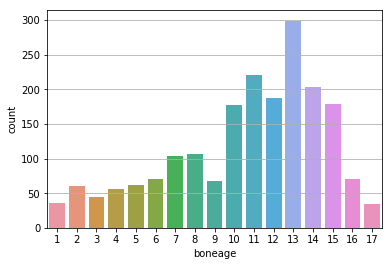

In [9]:
sns.countplot(boneage_target)
plt.show()

As addressed in the business case, we really care about minimizing the false negative rate of our predictive algorithm. To illustrate what precisely we care about, suppose a patient is given this screening process. Suppose then that the algorithm incorrectly gives their boneage to be something that it isn't, and the patient has to go through a couple other tests to find that they don't have some sort of endocrine dysfunction. Not much is lost here except a little bit of time. However, if the algorithm incorrectly predicts their bone age to be their actual age, this poses some serious problems.

This brings up the question of how to measure this hit/miss rate in the case of the data at hand, since we don't have both the bone age and actual age. However, it is almost certainly not very likely that the algorithm would incorrectly predict someone's bone age to be their actual age if there was a discrepancy. Thus, we are much more concerned with any given prediction being helpful than we are in picking up all of the examples of a given output class. Fortunately, precision scores measure for just this. 

As for addressing the issue of imbalanced classes, we note that we have the most instances of ages in late childhood and early adolescence. These ages are both young enough that endocrine disorders are more easily treatable and old enough that they might actually be detectable. So, conveniently, we have the most data on the classes we care most about. Because of this, we will use a micro-averaging scheme.

In [10]:
from sklearn.metrics import precision_score, confusion_matrix, make_scorer
avg_scheme = 'micro'
scorer = make_scorer(precision_score, average=avg_scheme)

## Cross-Validation Strategy

Due to our bevy of unbalanced classes, we will want to use a stratified cross-validation method to preserve class balance. As for the precise strategy, we should use k-fold, as the dataset isn't too large, and our algorithms should be able to manage it. 

In practice, the algorithm will usually be tasked with classifying an individual's age for a particular test. This is represented well by our CV strategy because, as previously mentioned, it should represent roughly the distribution of ages where this test is a concern.

We will tentatively try using 10 validation folds, unless that turns out to be too computationally expecnsive. In extreme cases, we may go to three.

In [11]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10)

## Image Augmentation

We would like to get our model to generalize well to unseen data, so let's include some perturbations of the images, so as not to train on identical data and overfit. 

First, let's get a rough idea of what kinds of variations we may see in the dataset and what might work well as augmentation strategies.

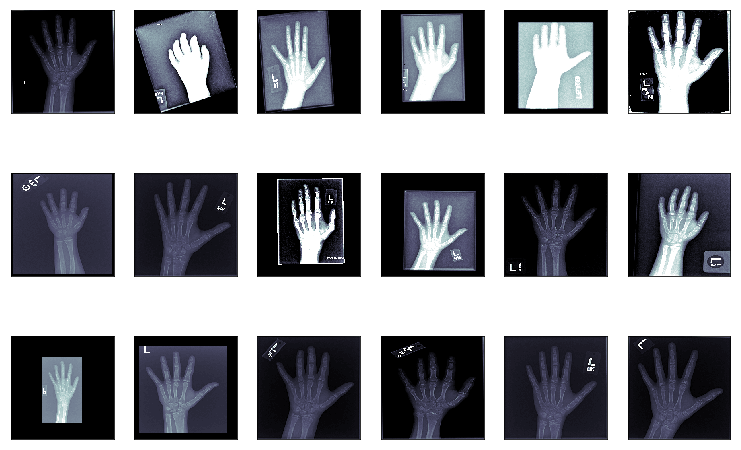

In [12]:
plot_gallery(boneage_df[np.random.choice(boneage_data.shape[0], 18), :], 256, 256)

Seeing some rotations within a few degrees here. The algorithm should also be robust to translations up to a quarter or so of the image. There are also horizontal flips and differences in scale which we should be able to deal with.

In [13]:
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0,
    zoom_range=0.1,
    fill_mode='nearest', #most of the time it's blank anyways
    cval=0,
    horizontal_flip=True,
    vertical_flip=False
)

datagen.fit(X_train)

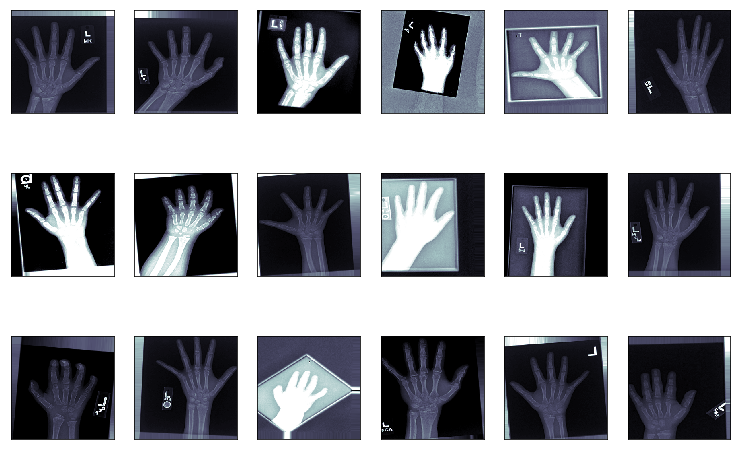

In [14]:
# flow = datagen.flow(X_train, y_train, batch_size=1)

def plot_datagen(datagen, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    flow = datagen.flow(X_train, y_train, batch_size=n_row*n_col)
    
    for img in flow:
        for i in range(n_row * n_col):
            plt.subplot(n_row, n_col, i+1)
            plt.imshow(img[0][i].squeeze().reshape((h,w)), cmap='bone')
            plt.xticks(())
            plt.yticks(())
        break
    plt.show()
    
plot_datagen(datagen, 256, 256)

## Building Some Models

In [15]:
def plot_history(history):
    plt.figure()
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')
    
    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')

In [16]:
%%time

cnn_generic=Sequential()

cnn_generic.add(Conv2D(filters=64, 
                   input_shape=(img_dim, img_dim, 1), 
                   kernel_size=(3,3), 
                   padding='same', 
                   activation='relu'))
        
cnn_generic.add(MaxPooling2D(pool_size=(4,4), 
                             data_format='channels_last'))

cnn_generic.add(Dropout(rate=0.2))

cnn_generic.add(Conv2D(filters=32, 
#                    input_shape=(img_dim, img_dim, 1), 
                   kernel_size=(3,3), 
                   padding='same', 
                   activation='relu'))
        
cnn_generic.add(MaxPooling2D(pool_size=(4,4), 
                             data_format='channels_last'))

cnn_generic.add(Dropout(rate=0.2))

# cnn_generic.add(Conv2D(filters=16, 
# #                    input_shape=(img_dim, img_dim, 1), 
#                    kernel_size=(3,3), 
#                    padding='same', 
#                    activation='relu'))
        
# cnn_generic.add(MaxPooling2D(pool_size=(4,4), 
#                              data_format='channels_last'))

# cnn_generic.add(Dropout(rate=0.2))

cnn_generic.add(Flatten())

cnn_generic.add(Dense(units=64, 
                  activation='relu', 
                  kernel_initializer='he_uniform'))
cnn_generic.add(Dropout(rate=0.2))

cnn_generic.add(Dense(units=n_classes, 
                  activation='softmax', 
                  kernel_initializer='glorot_uniform'))
cnn_generic.add(Dropout(rate=0.2))

cnn_generic.compile(loss='categorical_crossentropy',
                   optimizer=RMSprop(lr=1e-6),
                   metrics=['acc'])

cnn_generic.fit_generator(datagen.flow(X_train, y_train, batch_size=32),
                             steps_per_epoch=int(X_train.shape[0]/32),
                             epochs=10, verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='loss', 
                                                      patience=3)])

Epoch 1/10
46/46 [==============================] - 9s 205ms/step - loss: 5.2845 - acc: 0.0529 - val_loss: 2.8240 - val_acc: 0.0384
Epoch 2/10
46/46 [==============================] - 9s 195ms/step - loss: 5.1942 - acc: 0.0673 - val_loss: 2.8206 - val_acc: 0.0444
Epoch 3/10
46/46 [==============================] - 9s 191ms/step - loss: 5.1469 - acc: 0.0835 - val_loss: 2.8177 - val_acc: 0.0687
Epoch 4/10
46/46 [==============================] - 9s 192ms/step - loss: 4.9944 - acc: 0.0869 - val_loss: 2.8145 - val_acc: 0.0970
Epoch 5/10
46/46 [==============================] - 9s 192ms/step - loss: 5.2845 - acc: 0.0910 - val_loss: 2.8115 - val_acc: 0.1152
Epoch 6/10
46/46 [==============================] - 9s 192ms/step - loss: 5.0651 - acc: 0.0998 - val_loss: 2.8084 - val_acc: 0.1192
Epoch 7/10
46/46 [==============================] - 9s 194ms/step - loss: 5.4437 - acc: 0.0978 - val_loss: 2.8054 - val_acc: 0.1273
CPU times: user 1min 14s, sys: 3.66 s, total: 1min 18s
Wall time: 1min 3s


In [17]:
cnn_generic.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
__________

In [18]:
def predict_categ(model, data):
    return(np.argmax(model.predict(data), axis=1))

def evaluate_confusion(model, test_data, test_target, normalize=True, print_micro=True):
    target_int = np.argmax(test_target, axis=1)
    yhat = predict_categ(model, test_data)
    conf = confusion_matrix(target_int, yhat[:,np.newaxis])

    if normalize:
        conf = conf / np.unique(target_int, return_counts=True)[1][:, np.newaxis]
    if print_micro:
        print('Precision score of this model is {}'.format(precision_score(target_int, yhat, average='micro')))
        
    sns.heatmap(conf, annot=True)
    plt.show()

Precision score of this model is 0.12727272727272726


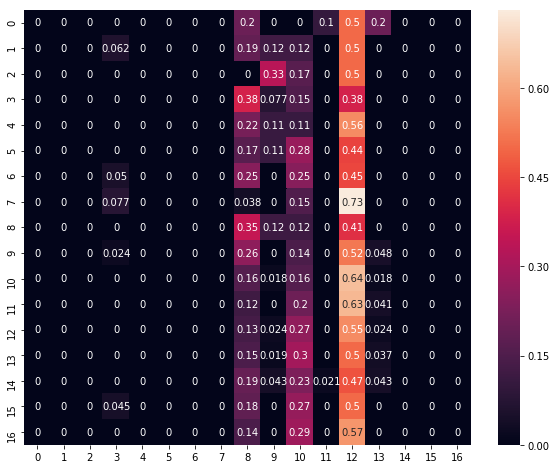

In [23]:
evaluate_confusion(cnn_generic, X_test, y_test)

A miserable failure. Not really sure what happened here.

In [ ]:
%%time

cnn_fix=Sequential()

cnn_fix.add(Conv2D(filters=64, 
                   input_shape=(img_dim, img_dim, 1), 
                   kernel_size=(3,3), 
                   padding='same', 
                   kernel_initializer='he_uniform',
                   activation='relu'))
        
cnn_fix.add(MaxPooling2D(pool_size=(2,2), 
                         data_format='channels_last'))

cnn_fix.add(Conv2D(filters=32, 
                   kernel_size=(3,3), 
                   padding='same',  
                   kernel_initializer='he_uniform',
                   activation='relu'))
        
cnn_fix.add(MaxPooling2D(pool_size=(2,2), 
                         data_format='channels_last'))
cnn_fix.add(Dropout(rate=0.2))

cnn_fix.add(Flatten())

cnn_fix.add(Dense(units=64, 
                      activation='relu', 
                      kernel_initializer='he_uniform'))
cnn_fix.add(Dropout(rate=0.2))

cnn_fix.add(Dense(units=n_classes, 
                      activation='softmax', 
                      kernel_initializer='glorot_uniform'))
cnn_fix.add(Dropout(rate=0.2))

cnn_fix.compile(loss='categorical_crossentropy',
                       optimizer=RMSprop(lr=1e-6),
                       metrics=['acc'])

cnn_fix.fit_generator(datagen.flow(X_train, y_train, batch_size=64),
                             steps_per_epoch=int(X_train.shape[0]/64),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='loss', 
                                                      patience=3)])

Epoch 1/10
23/23 [==============================] - 9s 411ms/step - loss: 5.4432 - acc: 0.0651 - val_loss: 2.7528 - val_acc: 0.1071
Epoch 2/10
22/23 [===========================>..] - ETA: 0s - loss: 5.3415 - acc: 0.0993

In [ ]:
evaluate_confusion(cnn_fix, X_test, y_test)

## What Went Wrong

In [87]:
cnn_bare = Sequential()

# cnn_bare.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
# cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
# cnn_bare.add(Dropout(0.2))
cnn_bare.add(Flatten())
cnn_bare.add(Dense(units=64, activation='relu'))
# cnn_bare.add(Dropout(0.2))
cnn_bare.add(Dense(units=n_classes, activation='softmax'))

cnn_bare.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['acc'])

history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
               validation_data=(X_test, y_test),
               callbacks=[EarlyStopping(monitor='loss', patience=3)])

# cnn_bare.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
#                              steps_per_epoch=int(X_train.shape[0]/16),
#                              epochs=10,
#                              verbose=1,
#                              validation_data=(X_test, y_test),
#                              callbacks=[EarlyStopping(monitor='loss', 
#                                                       patience=3)])

Train on 1485 samples, validate on 495 samples
Epoch 1/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.7615 - acc: 0.1468 - val_loss: 2.6486 - val_acc: 0.1293
Epoch 2/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.5701 - acc: 0.1630 - val_loss: 2.6825 - val_acc: 0.1414
Epoch 3/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.4784 - acc: 0.1838 - val_loss: 2.7205 - val_acc: 0.1333
Epoch 4/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.3764 - acc: 0.2465 - val_loss: 2.9084 - val_acc: 0.1414
Epoch 5/10
1485/1485 [==============================] - 9s 6ms/step - loss: 2.0950 - acc: 0.3677 - val_loss: 3.2196 - val_acc: 0.1253
Epoch 6/10
1485/1485 [==============================] - 9s 6ms/step - loss: 1.6772 - acc: 0.5111 - val_loss: 3.3000 - val_acc: 0.1111
Epoch 7/10
1485/1485 [==============================] - 9s 6ms/step - loss: 1.2879 - acc: 0.6391 - val_loss: 4.2731 - val_acc: 0.1152
Epoch 8/10
148

Precision score of this model is 0.9434343434343434


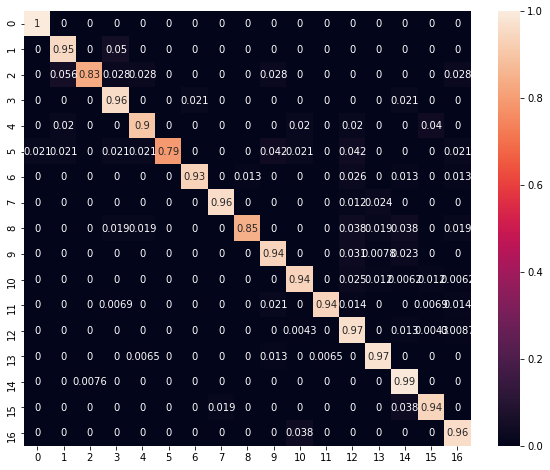

Precision score of this model is 0.13131313131313133


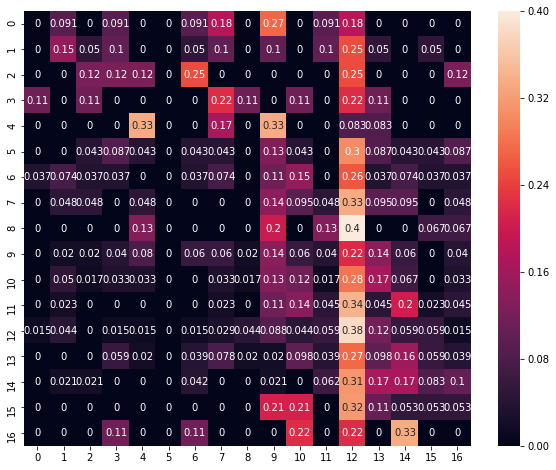

In [88]:
evaluate_confusion(cnn_bare, X_train, y_train)
evaluate_confusion(cnn_bare, X_test, y_test)

In [89]:
cnn_bare = Sequential()

# cnn_bare.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
# cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
# cnn_bare.add(Dropout(0.2))
cnn_bare.add(Flatten())
cnn_bare.add(Dense(units=64, activation='relu'))
# cnn_bare.add(Dropout(0.2))
cnn_bare.add(Dense(units=n_classes, activation='softmax'))

cnn_bare.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['acc'])

# history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
#                validation_data=(X_test, y_test),
#                callbacks=[EarlyStopping(monitor='loss', patience=3)])

cnn_bare.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
                             steps_per_epoch=int(X_train.shape[0]/16),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='loss', 
                                                      patience=3)])

Epoch 1/10
92/92 [==============================] - 9s 100ms/step - loss: 6.0097 - acc: 0.1223 - val_loss: 2.7205 - val_acc: 0.1414
Epoch 2/10
92/92 [==============================] - 9s 99ms/step - loss: 2.6963 - acc: 0.1414 - val_loss: 2.7312 - val_acc: 0.1414
Epoch 3/10
92/92 [==============================] - 9s 98ms/step - loss: 2.6531 - acc: 0.1391 - val_loss: 2.6379 - val_acc: 0.1354
Epoch 4/10
92/92 [==============================] - 9s 98ms/step - loss: 2.6208 - acc: 0.1428 - val_loss: 2.6584 - val_acc: 0.1192
Epoch 5/10
92/92 [==============================] - 9s 98ms/step - loss: 2.5942 - acc: 0.1578 - val_loss: 2.6506 - val_acc: 0.1333
Epoch 6/10
92/92 [==============================] - 9s 97ms/step - loss: 2.5809 - acc: 0.1579 - val_loss: 2.6008 - val_acc: 0.1556
Epoch 7/10
92/92 [==============================] - 9s 98ms/step - loss: 2.5569 - acc: 0.1623 - val_loss: 2.6437 - val_acc: 0.1535
Epoch 8/10
92/92 [==============================] - 9s 98ms/step - loss: 2.5546 - 

Precision score of this model is 0.1872053872053872


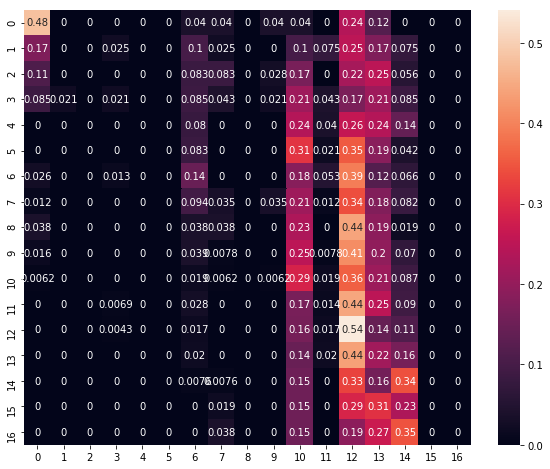

Precision score of this model is 0.1393939393939394


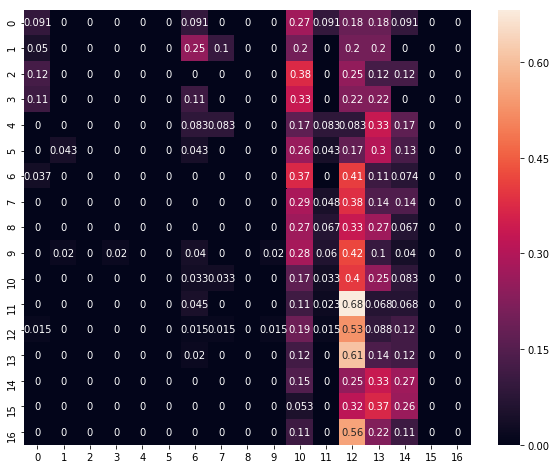

In [90]:
evaluate_confusion(cnn_bare, X_train, y_train)
evaluate_confusion(cnn_bare, X_test, y_test)

In [92]:
cnn_bare = Sequential()

# cnn_bare.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
# cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Dropout(0.2))
cnn_bare.add(Flatten())
cnn_bare.add(Dense(units=64, activation='relu'))
cnn_bare.add(Dropout(0.2))
cnn_bare.add(Dense(units=n_classes, activation='softmax'))

cnn_bare.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['acc'])

history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
               validation_data=(X_test, y_test),
               callbacks=[EarlyStopping(monitor='loss', patience=3)])

# cnn_bare.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
#                              steps_per_epoch=int(X_train.shape[0]/16),
#                              epochs=10,
#                              verbose=1,
#                              validation_data=(X_test, y_test),
#                              callbacks=[EarlyStopping(monitor='loss', 
#                                                       patience=3)])

Train on 1485 samples, validate on 495 samples
Epoch 1/10
1485/1485 [==============================] - 11s 7ms/step - loss: 2.8445 - acc: 0.1320 - val_loss: 2.6969 - val_acc: 0.1354
Epoch 2/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.6108 - acc: 0.1582 - val_loss: 2.6658 - val_acc: 0.1293
Epoch 3/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.5409 - acc: 0.1933 - val_loss: 2.7355 - val_acc: 0.1192
Epoch 4/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.4185 - acc: 0.2579 - val_loss: 2.8510 - val_acc: 0.1414
Epoch 5/10
1485/1485 [==============================] - 10s 7ms/step - loss: 2.2283 - acc: 0.3286 - val_loss: 3.3191 - val_acc: 0.1212
Epoch 6/10
1485/1485 [==============================] - 10s 7ms/step - loss: 1.9688 - acc: 0.4431 - val_loss: 3.4384 - val_acc: 0.1111
Epoch 7/10
1485/1485 [==============================] - 10s 7ms/step - loss: 1.6565 - acc: 0.5374 - val_loss: 3.6912 - val_acc: 0.1091
Epoch 8/

Precision score of this model is 0.9373737373737374


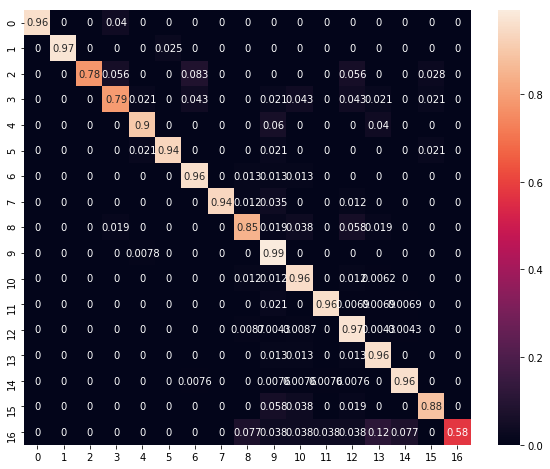

Precision score of this model is 0.10303030303030303


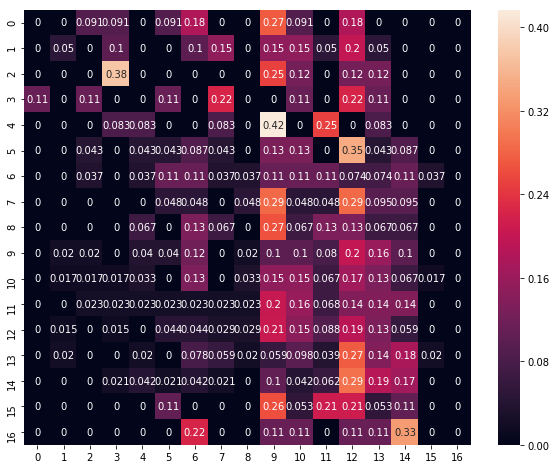

In [93]:
evaluate_confusion(cnn_bare, X_train, y_train)
evaluate_confusion(cnn_bare, X_test, y_test)

In [94]:
cnn_bare = Sequential()

# cnn_bare.add(Conv2D(filters=32, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
# cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Conv2D(filters=16, kernel_size=(2,2), input_shape=(img_dim, img_dim, 1), activation='relu'))
cnn_bare.add(MaxPooling2D((3,3), data_format='channels_last'))
cnn_bare.add(Dropout(0.2))
cnn_bare.add(Flatten())
cnn_bare.add(Dense(units=64, activation='relu'))
cnn_bare.add(Dropout(0.2))
cnn_bare.add(Dense(units=n_classes, activation='softmax'))

cnn_bare.compile(loss='categorical_crossentropy',
                       optimizer='rmsprop',
                       metrics=['acc'])

# history_bare = cnn_bare.fit(X_train, y_train, batch_size=1, epochs=10,
#                validation_data=(X_test, y_test),
#                callbacks=[EarlyStopping(monitor='loss', patience=3)])

cnn_bare.fit_generator(datagen.flow(X_train, y_train, batch_size=16),
                             steps_per_epoch=int(X_train.shape[0]/16),
                             epochs=10,
                             verbose=1,
                             validation_data=(X_test, y_test),
                             callbacks=[EarlyStopping(monitor='loss', 
                                                      patience=3)])

Epoch 1/10
92/92 [==============================] - 9s 101ms/step - loss: 3.3131 - acc: 0.1347 - val_loss: 2.8090 - val_acc: 0.1354
Epoch 2/10
92/92 [==============================] - 9s 100ms/step - loss: 2.7975 - acc: 0.1491 - val_loss: 2.7767 - val_acc: 0.1374
Epoch 3/10
92/92 [==============================] - 9s 99ms/step - loss: 2.7743 - acc: 0.1486 - val_loss: 2.7596 - val_acc: 0.1374
Epoch 4/10
92/92 [==============================] - 9s 98ms/step - loss: 2.7588 - acc: 0.1447 - val_loss: 2.7395 - val_acc: 0.1394
Epoch 5/10
92/92 [==============================] - 9s 98ms/step - loss: 2.7318 - acc: 0.1440 - val_loss: 2.7217 - val_acc: 0.1354
Epoch 6/10
92/92 [==============================] - 9s 98ms/step - loss: 2.7072 - acc: 0.1547 - val_loss: 2.6752 - val_acc: 0.1374
Epoch 7/10
92/92 [==============================] - 9s 98ms/step - loss: 2.6699 - acc: 0.1506 - val_loss: 2.6506 - val_acc: 0.1354ss: 2.6744 - acc: 0.1
Epoch 8/10
92/92 [==============================] - 9s 98ms/

Precision score of this model is 0.1622895622895623


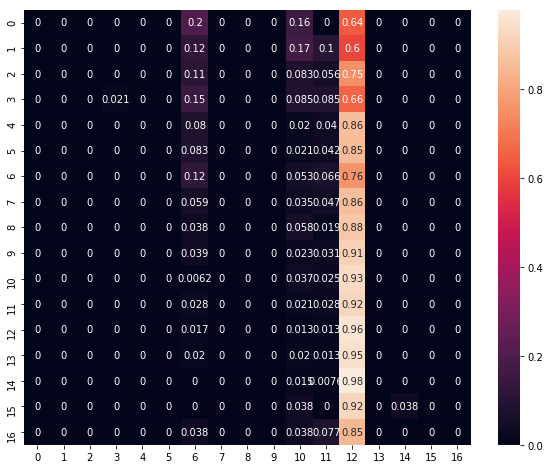

Precision score of this model is 0.13737373737373737


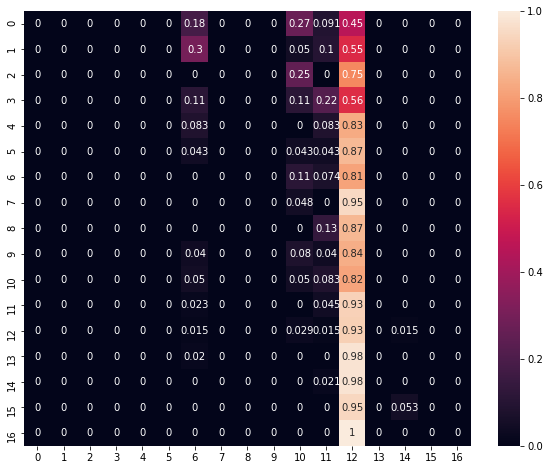

In [95]:
evaluate_confusion(cnn_bare, X_train, y_train)
evaluate_confusion(cnn_bare, X_test, y_test)

### Contrast Enhancement